In [1]:
! pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/9g/fz6w6gks1dq2j6bw3pg865kr0000gn/T/pip-req-build-ruvfjfml
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/9g/fz6w6gks1dq2j6bw3pg865kr0000gn/T/pip-req-build-ruvfjfml
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

In [3]:
if torch.cuda.is_available():
    dev = "cuda:0"
elif torch.backends.mps.is_available():
    dev = "mps"
else:
    dev = "cpu"
device = torch.device(dev)
device

device(type='mps')

download the model via https://github.com/facebookresearch/segment-anything#model-checkpoints

choose from 'vit_h' (best quality), 'vit_l' (medium), 'vit_b' (fastest)

In [4]:
MODEL_TYPE = "vit_b"
MODEL_PATH = "sam_vit_b_01ec64.pth"

# MODEL_TYPE = "vit_h"
# MODEL_PATH = "sam_vit_h_4b8939.pth"

initialize SAM model

In [5]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=MODEL_PATH)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


load predictor

In [6]:
predictor = SamPredictor(sam)

In [7]:
image_path = "../1_digital_image_processing/images/r2d2.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [8]:
predictor.set_image(image)

define a prompt (bounding box or points)

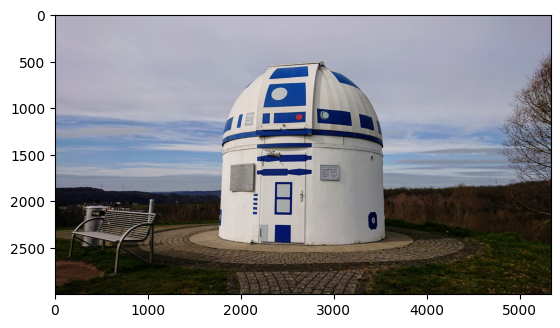

In [9]:
plt.imshow(image)

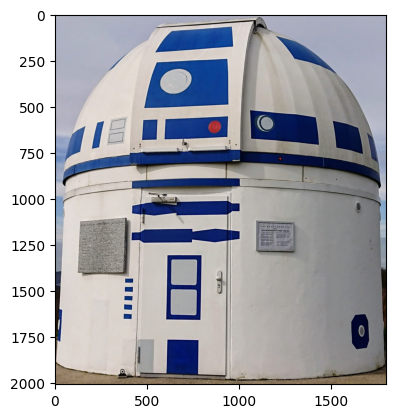

In [10]:
plt.imshow(image[490:2500, 1750:3550])

bounding box [x1, y1, x2, y2] prompt

In [11]:
input_box = np.array([1750, 490, 3550, 2500])

In [12]:
# get segmentation mask
masks, scores, logits = predictor.predict(box=input_box, multimask_output=False)

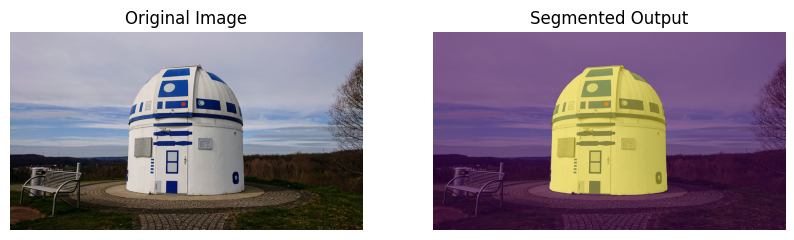

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image)
for mask in masks:
    plt.imshow(mask, alpha=0.5)  # overlay mask
plt.title("Segmented Output")
plt.axis("off")

plt.show()

point(s) prompt (x, y)

single point or multiple points possible

define label for each point: 1 for foreground (area to segment), 0 for background (area to exclude)

In [14]:
input_points = np.array([[2000, 1000], [1000, 1000]])
input_labels = np.array([1, 0])

In [15]:
masks, scores, logits = predictor.predict(box=input_box, point_coords=input_points, point_labels=input_labels, multimask_output=False)

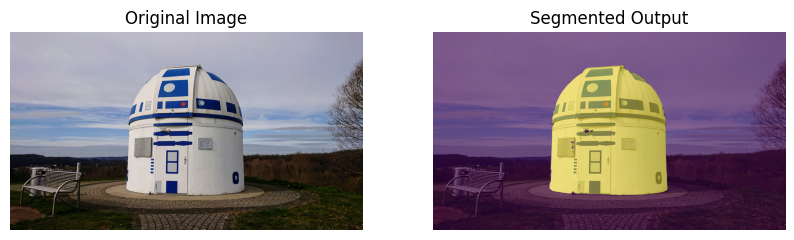

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image)
for mask in masks:
    plt.imshow(mask, alpha=0.5)  # overlay mask
plt.title("Segmented Output")
plt.axis("off")

plt.show()

using text as a prompt for SAM

While SAM (Segment Anything Model) itself does not natively support text prompts, one can combine SAM with CLIP (Contrastive Language-Image Pretraining) to achieve text-based segmentation:
- Use CLIP to detect image regions related to a given text prompt.
- Extract the region (bounding box or point) from CLIP.
- Pass the extracted region as a prompt to SAM for precise segmentation.

For an automated text-to-region mapping, one can use Grounding DINO instead of CLIP:
- Grounding DINO detects objects based on text.
- Pass detected bounding boxes to SAM for precise segmentation.